<a href="https://colab.research.google.com/github/sinheechan/ML/blob/main/%EC%95%99%EC%83%81%EB%B8%94%ED%95%99%EC%8A%B5_%EB%9E%9C%EB%8D%A4%ED%8F%AC%EB%A0%88%EC%8A%A4%ED%8A%B8_GBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. 초기 세팅

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

colors = sns.color_palette('husl')

## 2. 데이터 불러오기

In [ ]:
!wget https://archive.ics.uci.edu/static/public/240/human+activity+recognition+using+smartphones.zip

!unzip human+activity+recognition+using+smartphones.zip
!unzip UCI\ HAR\ Dataset.zip

## 3. EDA

### 3.1 데이터셋 가공하기

- 가장 먼저, features.txt를 불러와 피처의 갯수와 값을 살펴본다.
- feature.txt 파일에는 피처 이름 index와 피처명이 공백으로 분리되어져 있으므로  이를 DataFrame으로 로드한다.

In [4]:
feature_name_df = pd.read_csv("/content/UCI HAR Dataset/features.txt", sep = '\s+',
                              header = None, names = ['column_index', 'column_name'])

feature_name_df.head()

,column_index,column_name
0,1,tBodyAcc-mean()-X
1,2,tBodyAcc-mean()-Y
2,3,tBodyAcc-mean()-Z
3,4,tBodyAcc-std()-X
4,5,tBodyAcc-std()-Y


- 피처명 index를 제거하고, 피처명만 리스트 객체로 생성한 뒤 샘플로 10개만 추출한다.

In [5]:
feature_name = feature_name_df.iloc[:,1].values.tolist()
print('전체 피처명에서 10개만 추출:', feature_name[:10])

전체 피처명에서 10개만 추출: ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X']


- 피처명을 보았을 때 움직임과 관련된 속성의 평균, 표준편차가 x,y,z축 값으로 되어 있음을 유추할 수 있다.
- 이를 데이터 프레임으로 변환하기 전에, 중복된 피처명에 대해서 구분지어주어야 한다.

In [6]:
# 중복된 피처명이 있는지 알아보기

feature_dup_df = feature_name_df.groupby('column_name').count()
print(feature_dup_df[feature_dup_df['column_index']>1].count())
feature_dup_df[feature_dup_df['column_index']>1].head()

column_index    42
dtype: int64


,column_index
column_name,
"fBodyAcc-bandsEnergy()-1,16",3
"fBodyAcc-bandsEnergy()-1,24",3
"fBodyAcc-bandsEnergy()-1,8",3
"fBodyAcc-bandsEnergy()-17,24",3
"fBodyAcc-bandsEnergy()-17,32",3


- 중복된 피처명이 총 42개가 존재하고, 각각의 갯수들을 확인할 수 있다.
- 이러한 중복된 피처명에 _1,_2를 추가로 부여해 새로은 데이터프레임을 가지는 get_new_feature_name_df()를 생성하였다.

In [10]:
# 중복된 피처명에 _1, _2를 추가하여 새로운 피처명을 가지는 dataframe으로 반환하는 함수 생성

def get_new_feature_name_df(old_feature_name_df):
  feature_dup_df = pd.DataFrame(data = old_feature_name_df.groupby('column_name').cumcount(),
                                columns = ['dup_cnt'])
  feature_dup_df = feature_dup_df.reset_index()
  new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how = 'outer')
  new_feature_name_df['column_name'] = new_feature_name_df[['column_name',
                                                             'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1])
                                                             if x[1] > 0 else x[0] , axis = 1)
  new_feature_name_df = new_feature_name_df.drop(['index'], axis = 1)
  return new_feature_name_df

- get_new_feature_name_df를 생성해준 뒤, features.txt 속성에 적용시켜주고, 데이터 셋에 있는 train, test 파일의 피처 데이터 파일과 레이블 데이터 파일을 불러와준다.

- 레이블 데이터 파일의 레이블 속성은 'action'으로 지정해주고, get_new_feature_df 함수를 적용시켜 데이터프레임을 만드는 일이 종종 발생하기 때문에 이를 적용시켜주는 get_human_dataset() 함수를 새롭게 생성해준다.
- 결론적으로 모델을 생성하기 전에 데이터 셋을 분리해주어야 하는데, 분리하는 것까지 포함한 get_human_dataset()을 데이터 셋 분리할 때 적용시켜주었다.

In [15]:
import pandas as pd

def get_human_dataset( ):

  # 각 데이터 파일은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당
  feature_name_df = pd.read_csv("/content/UCI HAR Dataset/features.txt", sep = '\s+',
                                header = None, names = ['column_index','column_name'])
  # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame 생성
  new_feature_name_df = get_new_feature_name_df(feature_name_df)

  # DataFrame에 피처명을 칼럼으로 부여하기 위해 리스트 객체로 다시 변환
  feature_name = new_feature_name_df.iloc[:,1].values.tolist()

  # 학습 피처 데이터세트와 테스트 피처 데이터를 DataFrame으로 로딩. 칼럼명은 feature_name 적용
  X_train = pd.read_csv("/content/UCI HAR Dataset/train/X_train.txt", sep = '\s+', names = feature_name)
  X_test = pd.read_csv("/content/UCI HAR Dataset/test/X_test.txt", sep = '\s+', names = feature_name)

  # 학습 레이블과 테스트 레이블 데이터를 DataFrame으로 로딩하고 칼럼명은 action으로 부여
  y_train = pd.read_csv("/content/UCI HAR Dataset/train/y_train.txt", sep = '\s+', header = None, names = ['action'])
  y_test = pd.read_csv("/content/UCI HAR Dataset/test/y_test.txt",sep = '\s+', header = None, names = ['action'])

  # 로드된 학습/테스트용 DataFrame을 모두 반환
  return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_human_dataset()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7352, 561) (7352, 1)
(2947, 561) (2947, 1)


### 3.2 데이터셋 살펴보기

In [18]:
print("##### X_train info 값 #####")
X_train.info()

print("-" * 100)

print("##### y_train info 값 #####")
y_train.info()

print("-" * 100)

print("##### X_test info 값 #####")
X_test.info()

print("-" * 100)

print("##### y_test info 값 #####")
y_test.info()

##### X_train info 값 #####
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB
----------------------------------------------------------------------------------------------------
##### y_train info 값 #####
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   action  7352 non-null   int64
dtypes: int64(1)
memory usage: 57.6 KB
----------------------------------------------------------------------------------------------------
##### X_test info 값 #####
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2947 entries, 0 to 2946
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 12.6 MB
----------------------------------------------------------------------------------------------------
#####

In [22]:
print(y_train["action"].value_counts())
print("-" * 100)
print(y_test["action"].value_counts())

6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: action, dtype: int64
----------------------------------------------------------------------------------------------------
6    537
5    532
1    496
4    491
2    471
3    420
Name: action, dtype: int64


- 데이터 셋을 확인해보면, 학습 데이터 셋에는 7352개의 값과 561개의 피처를 가지고 있으며 모두 float 형태이기 때문에 인코딩을 진행시켜 주지 않아도 된다.

- 테스트 데이터 셋에는 1 ~ 6까지의 레이블이 존재한다.

## 4. 머신러닝_결정트리

### 4.1 모델 생성 및 적용

- DecisionTreeClassifier(결정트리 분류기)를 불러온 뒤 기본 파라미터를 이용하여 데이터를 학습, 예측을 해주었다.

- 결론적으로 정확도와 기본 하이퍼 파라미터에 해당하는 값에 어떤 값을 사용했는지 출력해보았다.

In [23]:
# 의사결정나무로 분류하기
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# 예제 반복 시마다 동일한 예측 결과 도출을 위해 random_state 설정
dt_clf = DecisionTreeClassifier(random_state = 2024)
dt_clf.fit(X_train, y_train)

# 예측결과
pred = dt_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print("결정트리 예측 정확도: {0:.4f}".format(accuracy))

# DecisionTreeClassifier의 하이퍼 파라미터 추출
print("DecisionTreeClassifier 기본 하이퍼 파라미터:\n", dt_clf.get_params())

결정트리 예측 정확도: 0.8571
DecisionTreeClassifier 기본 하이퍼 파라미터:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 2024, 'splitter': 'best'}


- 결정트리의 하이퍼 파라미터 중 max_depth의 최적값을 찾기 위해 값을 변화 시키면서 예측성능을 확인해보았다.
- min_samples_split은 16으로 고정하였다.

In [24]:
# GridSearchCV 실행
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth' : [6,8,10,12,16,20,24],
    'min_samples_split' : [16]
}

grid_cv = GridSearchCV(dt_clf, param_grid = params, scoring = 'accuracy', cv = 5, verbose = 1)
grid_cv.fit(X_train, y_train)

print('GridSearchCV 최고 평균 정확도 수치: {0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터:', grid_cv.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
GridSearchCV 최고 평균 정확도 수치: 0.8486
GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 10, 'min_samples_split': 16}


- max_depth 파라미터 값에 따른 테스트 세트, 학습 데이터 세트의 정확도 수치를  추출한다.

In [26]:
# GridSearchCV 객체의 cv_results_ 속성을 DataFrame으로 생성
cv_results_df = pd.DataFrame(grid_cv.cv_results_)

# max_depth 파라미터 값과 그때의 테스트 세트, 학습 데이터 세트의 정확도 수치 추출
cv_results_df[['param_max_depth', 'mean_test_score']]

,param_max_depth,mean_test_score
0,6,0.848207
1,8,0.847668
2,10,0.848622
3,12,0.841142
4,16,0.843590
5,20,0.842231
6,24,0.842231


- 결론적으로 max_depth 가 8일때, 모델의 정확도 성능이 0.8548에서 0.8549로 상승한 것을 알 수 있다.

- 다음으로 별도의 테스트 데이터 셋에서 minsamples_split은 16으로 고정하고, max_depth의 변화에 따른 값을 측정해보았다.

In [25]:
max_depths = [6,8,10,12,16,20,24]

# max_depth 값을 변화시키면서 그때마다 학습과 테스트 세트에서의 예측 성능 측정
for depth in max_depths:
  dt_clf = DecisionTreeClassifier(max_depth = depth, min_samples_split = 16, random_state = 156)
  dt_clf.fit(X_train, y_train)
  pred = dt_clf.predict(X_test)
  accuracy = accuracy_score(y_test, pred)
  print('max_depth = {0} 정확도: {1:.4f}'.format(depth, accuracy))

max_depth = 6 정확도: 0.8551
max_depth = 8 정확도: 0.8717
max_depth = 10 정확도: 0.8599
max_depth = 12 정확도: 0.8571
max_depth = 16 정확도: 0.8599
max_depth = 20 정확도: 0.8565
max_depth = 24 정확도: 0.8565


- 테스트 데이터 셋에서도 mox_depth가 8일 때 87.17%로 가장 성능이 좋게 나왔다.
- 다음으로는 min_samples_split도 변화를 주면서 정확도 성능을 튜닝해보았다.

In [27]:
params = {
    'max_depth' : [6,8,10,12,16,20,24],
    'min_samples_split' : [16, 24]
}

grid_cv = GridSearchCV(dt_clf, param_grid = params, scoring = 'accuracy', cv = 5, verbose = 1)
grid_cv.fit(X_train, y_train)
print('GridSearchCV 최고 평균 정확도 수치: {0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터:', grid_cv.best_params_)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
GridSearchCV 최고 평균 정확도 수치: 0.8549
GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 8, 'min_samples_split': 16}


- best_estimator_을 이용하여 테스트 데이터 셋의 최고 정확도가 무엇인지 알아보았다.

In [29]:
best_df_clf = grid_cv.best_estimator_
pred1 = best_df_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred1)

print('결정트리 예측 정확도:{0:.4f}'.format(accuracy))

결정트리 예측 정확도:0.8717


- 마지막으로 결정 트리에서 각 피처의 중요도를 feature_importances_ 속성을 이용해 알아본다.

<ipython-input-34-506d82cd37eb>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = ftr_top20, y = ftr_top20.index, palette = colors)
<ipython-input-34-506d82cd37eb>:10: UserWarning: 
The palette list has fewer values (6) than needed (20) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x = ftr_top20, y = ftr_top20.index, palette = colors)


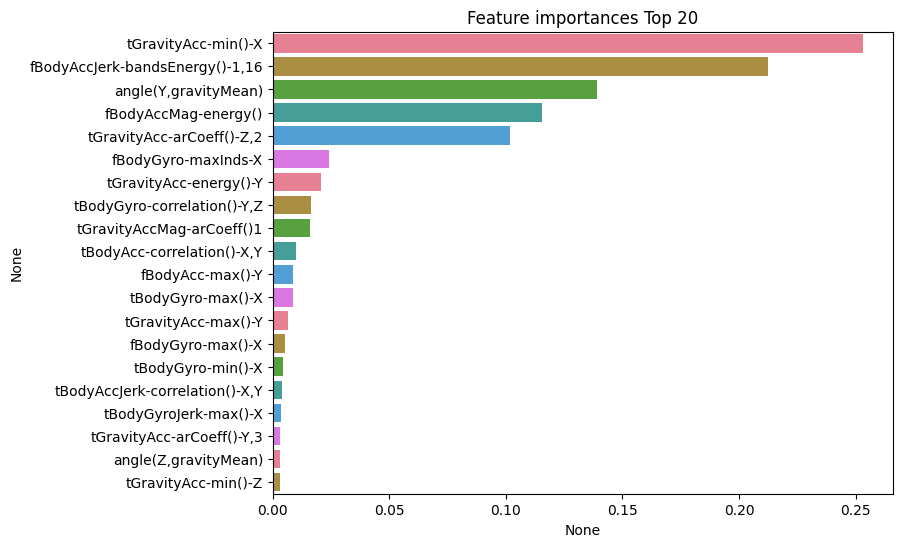

In [34]:
ftr_importances_values = best_df_clf.feature_importances_

# Top 중요도로 정렬을 쉽게 하고, 시본의 막대그래프로 쉽게 표현하기 위해 Series 변환
ftr_importances = pd.Series(ftr_importances_values, index = X_train.columns)

# 중요도값 순으로 Series를 정렬
ftr_top20 = ftr_importances.sort_values(ascending = False)[:20]
plt.figure(figsize = (8,6))
plt.title('Feature importances Top 20')
sns.barplot(x = ftr_top20, y = ftr_top20.index, palette = colors)
plt.show()

## 5. 머신러닝_랜덤포레스트

- 파라미터 값을 default로 랜덤 포레스트 모델로 정확도를 측정한다.

In [37]:
# 랜덤 포레스트 학습 및 별도의 테스트 세트로 예측 성능 평가
rf_clf = RandomForestClassifier(random_state=221)
rf_clf.fit(X_train, y_train)

pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)

print('랜덤 포레스트 정확도: {:.4f}'.format(accuracy))

<ipython-input-37-7272f9ed7812>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_clf.fit(X_train, y_train)


랜덤 포레스트 정확도: 0.9220


- 파라미터 값을 default로 수행한 결과, 랜덤포레스트는 사용자 행동 인식 데이터셋에 92.20%의 정확도를 보인다.

- RandomForest의 하이퍼 파라미터 default 상태를 확인한다.

In [41]:
model_default = RandomForestClassifier()

print("RandomForestClassifier의 기본 매개변수:\n", model_default.get_params())

RandomForestClassifier의 기본 매개변수:
 {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


- GridSearchCV를 통한 랜덤포레스트의 하이퍼파라미터 튜닝을 진행한다.

In [42]:
from sklearn.model_selection import GridSearchCV

params = {'n_estimators' : [10, 100],
          'max_depth' : [6, 8, 10, 12],
          'min_samples_leaf' : [8, 12, 18],
          'min_samples_split' : [8, 16, 20]
          }

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state = 221, n_jobs = -1)
grid_cv = GridSearchCV(rf_clf,
                       param_grid = params,
                       cv = 3,
                       n_jobs = -1)
grid_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터: ', grid_cv.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_cv.best_score_))

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


최적 하이퍼 파라미터:  {'max_depth': 12, 'min_samples_leaf': 12, 'min_samples_split': 8, 'n_estimators': 100}
최고 예측 정확도: 0.9193


- max_depth : 12 , min_samples_leaf : 12 , min_samples_split : 8 , n_estimators : 100 일 때, 정확도가 91.93%로 측정되었다.
- 앞선 결정트리 모델의 예측값 87% 보다 향상된 예측 성과를 보였다.

- 이번에는 이 파라미터로 RandomForestClassifier를 다시 학습시킨 뒤, test 데이터셋에서 예측성능을 측정해본다.

In [43]:
rf_clf1 = RandomForestClassifier(n_estimators = 100,
                                max_depth = 12,
                                min_samples_leaf = 12,
                                min_samples_split = 8,
                                random_state = 0,
                                n_jobs = -1)

rf_clf1.fit(X_train, y_train)
pred = rf_clf1.predict(X_test)

print('예측 정확도: {:.4f}'.format(accuracy_score(y_test,pred)))

<ipython-input-43-13be9a244d45>:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_clf1.fit(X_train, y_train)


예측 정확도: 0.9213


- 랜덤포레스트의 각 피처 중요도를 시각화한다.
- 본 중요도는 max_depth : 12 , min_samples_leaf : 12 , min_samples_split : 8 , n_estimators : 100 일 때, 어떤 피처가 크게 영향을 미쳤는지 파악하는 것을 목적으로 한다.

<ipython-input-44-acbbf5e9e164>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ftr_top20, y=ftr_top20.index, palette = colors)
<ipython-input-44-acbbf5e9e164>:7: UserWarning: 
The palette list has fewer values (6) than needed (20) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x=ftr_top20, y=ftr_top20.index, palette = colors)


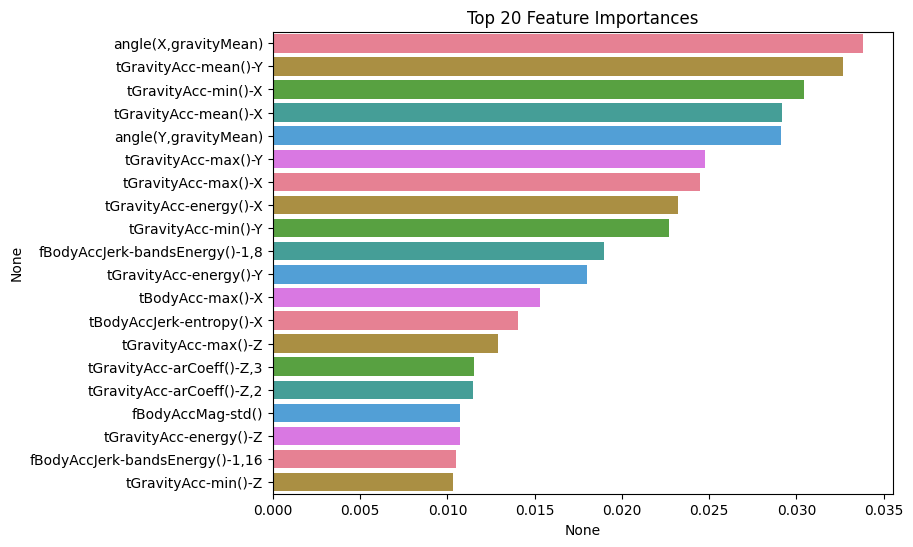

In [44]:
ftr_importances_values = rf_clf1.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Top 20 Feature Importances')
sns.barplot(x=ftr_top20, y=ftr_top20.index, palette = colors)
plt.show()